## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from matplotlib import ticker
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima

In [2]:
df = pd.read_csv("AZN-AstraZeneca.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,41.610001,41.759998,41.480000,41.759998,36.845528,4590000
1,2019-03-04,41.730000,41.810001,41.389999,41.689999,36.783760,3948200
2,2019-03-05,41.560001,42.610001,41.560001,42.310001,37.330803,5668200
3,2019-03-06,42.360001,42.389999,41.930000,42.029999,37.083748,2490000
4,2019-03-07,41.610001,41.770000,41.330002,41.660000,36.757298,5283900
...,...,...,...,...,...,...,...
1254,2024-02-23,64.959999,65.930000,64.949997,65.830002,65.830002,7388200
1255,2024-02-26,66.080002,66.370003,65.750000,65.930000,65.930000,4597900
1256,2024-02-27,65.940002,66.459999,65.769997,66.330002,66.330002,4433500
1257,2024-02-28,65.459999,65.779999,65.160004,65.349998,65.349998,6030600


## Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

## Data normalization

In [5]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

## Data splitting

In [6]:
# Split the data into training, validation and test dataset in a ratio of 7:3
train_size = int(0.7 * len(data_scaled))
test_size = len(data_scaled) - train_size

train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

## Model training and testing

## Training process

In [7]:
# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

In [8]:
# Find the best ARIMA model using auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4075.778, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4075.052, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4082.531, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4082.291, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4076.240, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4080.599, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4080.597, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4078.655, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4083.516, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4081.603, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4081.598, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4083.260, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4079.397, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.066 seconds


In [9]:
# Fit the model
model.fit(y_train)

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Validate Processing

## Testing Processing

In [10]:
x_test = np.array(range(train_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred = model.predict(n_periods=len(y_test))

## Evaluate Model

In [11]:
# Evaluate the accuracy of test
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.05731995538433216
RMSE on Test dataset:  4.893412281559771
MSLE on Test dataset:  0.005519567161026576


# Predicting the next 90 days

## Preparing the prediction data

In [12]:
# The process of creating index predict next 90 days
last_index = df_Close.index[-1]

# Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index + 1, last_index + 91)).reshape(-1, 1)

## Prediction process

In [13]:
# Predict the closing prices for the next 90 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days))
y_next_90_days = scaler.inverse_transform(np.array([y_next_90_days]).reshape(-1, 1))

# Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days.flatten())

Predicted closing prices for the next 90 days:
[66.51927683 66.49880713 66.50090978 66.50069379 66.50071598 66.5007137
 66.50071393 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391 66.50071391
 66.5

## Preparing the forecast date index

In [14]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

## Visualization

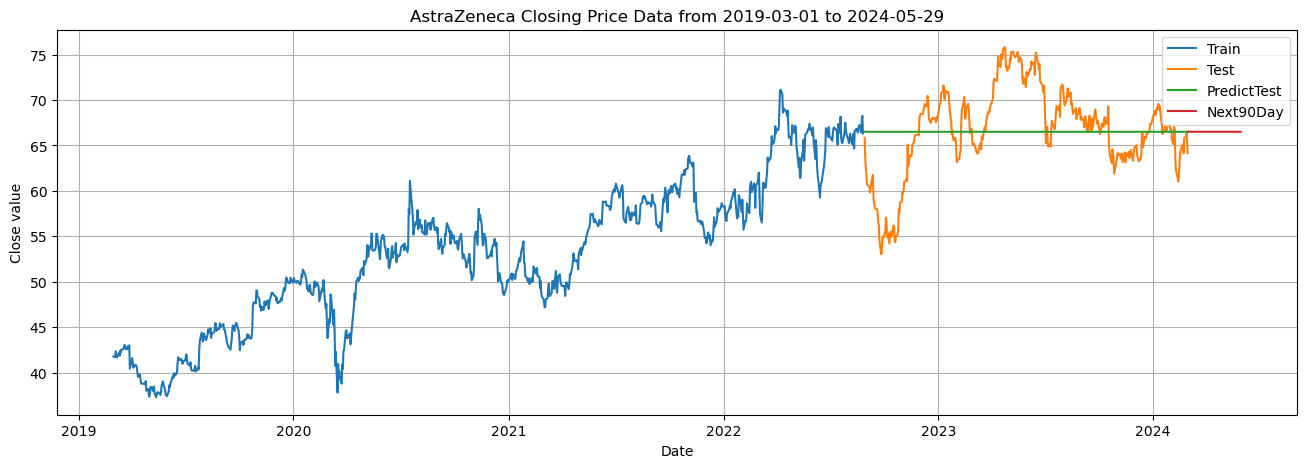

In [15]:
# Drawing
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([y_train]).reshape(-1, 1)))
plt.plot(df.index[train_size:], y_test)
plt.plot(df.index[train_size:], y_pred)
plt.plot(index_next_90_days, y_next_90_days)

plt.legend(['Train', 'Test', 'PredictTest', 'Next90Day'])
plt.grid()
plt.title(f"AstraZeneca Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('image/ARIMA_73_90day_AZN.png')
plt.show()